# Exercício 3 de Análise de Componentes Independentes em imagens


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.cluster.vq import whiten
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.stats import entropy, chi2_contingency, shapiro
from scipy.misc import imread
from sklearn.decomposition import PCA


%matplotlib inline
from evaluation import calculateNegentropy, kde_entropy, KLdivergence, resultsTable, plot_MutualInformation
from ICAfunctions import cichocki_Feedback, cichocki_Feedforward, NPCA_RLS

#Notes:
#SHAPIRO: The algorithm used is described in [R634] but censoring parameters as 
#        described are not implemented. For N > 5000 the W test statistic is 
#        accurate but the p-value may not be.

In [2]:
def rebuildPicture(x_r, x_g, x_b, original_shape):
    rebuilt = np.zeros(original_shape, np.float64)
    
    x_r = x_r-np.min(x_r)
    x_r = x_r/np.amax(x_r)
    
    x_g = x_g-np.min(x_g)
    x_g = x_g/np.amax(x_g)
    
    x_b = x_b-np.min(x_b)
    x_b = x_b/np.amax(x_b)
    
    rebuilt[:, :, 0] = np.reshape(x_r, (original_shape[0], original_shape[1]))
    rebuilt[:, :, 1] = np.reshape(x_g, (original_shape[0], original_shape[1]))
    rebuilt[:, :, 2] = np.reshape(x_b, (original_shape[0], original_shape[1]))
    
    return rebuilt

def image_histogram_equalization(image, number_bins=256):
    
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)


def rgb_ICA(ICA_method, mixturesRGB, learningRate, runs = 2, decay = False):
    #y = np.zeros(mixturesRGB.shape)

    print(mixturesRGB[:, :, 0].shape)
    
    [y_r, Wr] = ICA_method(mixturesRGB[:, :, 0], learningRate, runs = runs, decay = decay)
    #[y_g, Wg] = ICA_method(mixturesRGB[:, :, 1], learningRate, runs = runs)
    #[y_b, Wb] = ICA_method(mixturesRGB[:, :, 2], learningRate, runs = runs)
    
    pca = PCA(whiten=True)
    whitenedMixturesG = pca.fit_transform(mixturesRGB[:,:,1].T).T
    whitenedMixturesB = pca.fit_transform(mixturesRGB[:,:,2].T).T

    
    y_g = np.dot(Wr, whitenedMixturesG)
    y_b = np.dot(Wr, whitenedMixturesB)
    print(y_r.shape)
    
    y = np.dstack((y_r, y_g, y_b))
    
    print(y.shape)
    
    plt.imshow(np.reshape(y[0,:,0], (400, 500)))
    plt.show()
    
    W = [Wr, Wr, Wr]
    #W = Wr
    
    return y, W




def read_rgb_image(folderPath, n_images = 2, n_channels = 3):
    
    X1 = imread(folderPath + '\\1_saida.jpg', flatten = False)
    X2 = imread(folderPath + '\\2_saida.jpg', flatten = False)
    X3 = imread(folderPath + '\\3_saida.jpg', flatten = False)
    X4 = imread(folderPath + '\\4_saida.jpg', flatten = False)

    
    mixtures = np.zeros((n_images, X1.shape[0]*X1.shape[1], n_channels), np.float64)

    mixtures[0, :, 0] = X1[:,:,0].flatten()
    mixtures[0, :, 1] = X1[:,:,1].flatten()
    mixtures[0, :, 2] = X1[:,:,2].flatten()
    
    mixtures[1, :, 0] = X2[:,:,0].flatten()
    mixtures[1, :, 1] = X2[:,:,1].flatten()
    mixtures[1, :, 2] = X2[:,:,2].flatten()
    
    mixtures[2, :, 0] = X2[:,:,0].flatten()
    mixtures[2, :, 1] = X2[:,:,1].flatten()
    mixtures[2, :, 2] = X2[:,:,2].flatten()   
    
    mixtures[3, :, 0] = X2[:,:,0].flatten()
    mixtures[3, :, 1] = X2[:,:,1].flatten()
    mixtures[3, :, 2] = X2[:,:,2].flatten()
    
    original_shape = X1.shape

    return mixtures, original_shape


In [3]:
learning_rate = 1e-6
n_images = 4

In [4]:
folderPath = 'base_imagens_ica\\3_run'
mixtures, original_shape = read_rgb_image(folderPath, n_images)
print(mixtures.shape)
print(original_shape)

(4, 200000, 3)
(400, 500, 3)


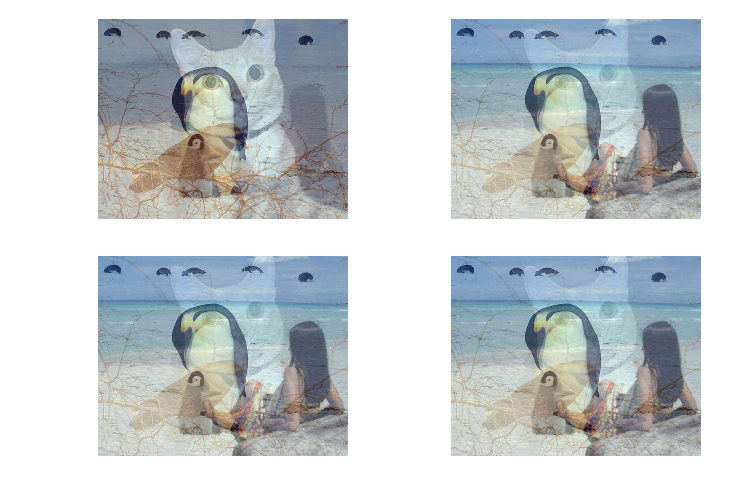

In [5]:
picture1 = rebuildPicture(mixtures[0, :, 0], mixtures[0, :, 1], mixtures[0, :, 2], original_shape)
picture2 = rebuildPicture(mixtures[1, :, 0], mixtures[1, :, 1], mixtures[1, :, 2], original_shape)
picture3 = rebuildPicture(mixtures[2, :, 0], mixtures[2, :, 1], mixtures[2, :, 2], original_shape)
picture4 = rebuildPicture(mixtures[3, :, 0], mixtures[3, :, 1], mixtures[3, :, 2], original_shape)

fig, axes = plt.subplots(2,2, dpi = 128, sharey = True, sharex= True)
axes[0,0].imshow(picture1)
axes[0,1].imshow(picture2)
axes[1,0].imshow(picture3)
axes[1,1].imshow(picture4)

axes[0,0].axis('off')
axes[0,1].axis('off')
axes[1,0].axis('off')
axes[1,1].axis('off')


fig.tight_layout()

## NPCA-RLS Algorithm

(4, 200000)
Execution time: 15.35915493965149 seconds
(4, 200000)
(4, 200000, 3)


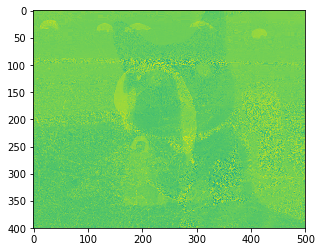

In [24]:
[yNPCA, WNPCA] = rgb_ICA(NPCA_RLS, mixtures, (1/1+1e-12), runs = 1)

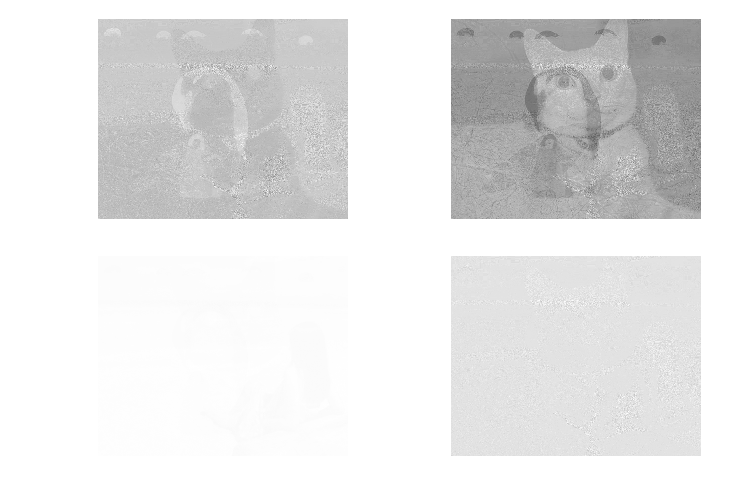

In [30]:
fig, axes = plt.subplots(2,2, dpi = 128, sharey = True, sharex= True)

catNPCA = rebuildPicture(yNPCA[1, :, 0], yNPCA[1, :, 1], -yNPCA[1, :, 2], original_shape)
womanNPCA = rebuildPicture(-yNPCA[2, :, 0], -yNPCA[2, :, 1], -yNPCA[0, :, 2], original_shape)
pinguimNPCA = rebuildPicture(yNPCA[0, :, 0], yNPCA[0, :, 1], -yNPCA[1, :, 2], original_shape)
otherNPCA = rebuildPicture(yNPCA[0, :, 0], yNPCA[3, :, 1], -yNPCA[1, :, 2], original_shape)

axes[0, 0].imshow(np.reshape(yNPCA[0,:,0], (400,500)), cmap = 'gray')
axes[0, 1].imshow(np.reshape(yNPCA[1,:,0], (400,500)), cmap = 'gray')
axes[1, 0].imshow(np.reshape(-yNPCA[2,:,0], (400,500)), cmap = 'gray')
axes[1, 1].imshow(np.reshape(-yNPCA[3,:,0], (400,500)), cmap = 'gray')
axes[0, 0].axis('off')
axes[0, 1].axis('off')
axes[1, 0].axis('off')
axes[1, 1].axis('off')

fig.tight_layout()

## Cichocki-Unbehauen Algorithm Feedback Network

(4, 200000)
Execution time: 38.968201637268066 seconds
(4, 200000)
(4, 200000, 3)


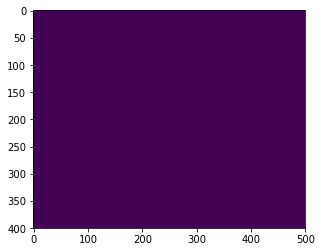

In [26]:
[yFeedback, WFeedback] = rgb_ICA(cichocki_Feedback, mixtures, 1.5e-3)

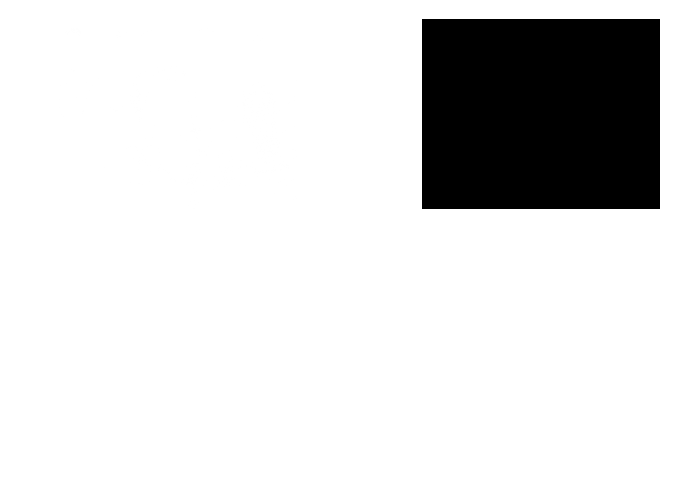

In [27]:
fig, axes = plt.subplots(2,2, dpi = 128)

axes[0, 0].imshow(np.reshape(yFeedback[0,:,1], (400,500)), cmap = 'gray')
axes[0, 1].imshow(np.reshape(yFeedback[1,:,1], (400,500)), cmap = 'gray')
axes[1, 0].imshow(np.reshape(-yFeedback[2,:,1], (400,500)), cmap = 'gray')
axes[1, 1].imshow(np.reshape(-yFeedback[3,:,1], (400,500)), cmap = 'gray')

axes[0, 0].axis('off')
axes[0, 1].axis('off')
axes[1, 0].axis('off')
axes[1, 1].axis('off')

fig.tight_layout()

## Cichocki-Unbehauen Algorithm Feedforward Network

(4, 200000)
Execution time: 24.527184009552002 seconds
(4, 200000)
(4, 200000, 3)


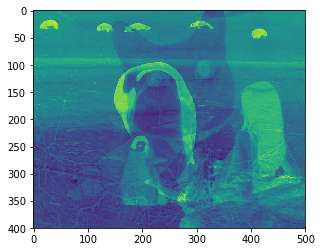

In [28]:
[yFeedForward, WFeedforward] = rgb_ICA(cichocki_Feedforward, mixtures, 1e-7)

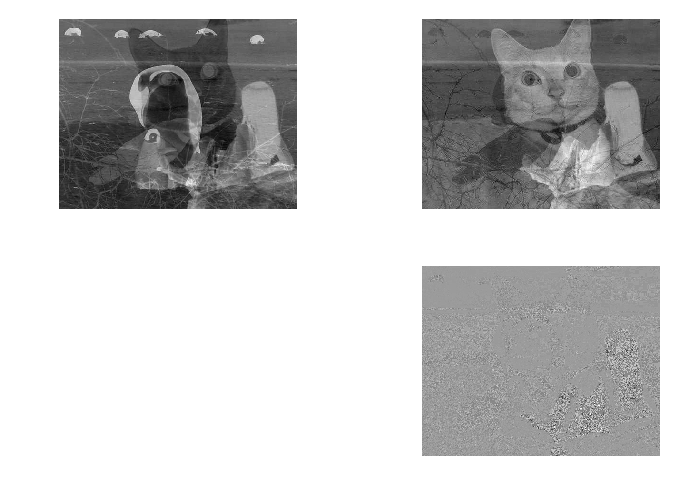

In [29]:
fig, axes = plt.subplots(2,2, dpi = 128)

axes[0, 0].imshow(np.reshape(yFeedForward[0,:,1], (400,500)), cmap = 'gray')
axes[0, 1].imshow(np.reshape(yFeedForward[1,:,1], (400,500)), cmap = 'gray')
axes[1, 0].imshow(np.reshape(-yFeedForward[2,:,1], (400,500)), cmap = 'gray')
axes[1, 1].imshow(np.reshape(-yFeedForward[3,:,1], (400,500)), cmap = 'gray')

axes[0, 0].axis('off')
axes[0, 1].axis('off')
axes[1, 0].axis('off')
axes[1, 1].axis('off')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.tight_layout()